In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt

from tqdm import tqdm

import feather

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import xgboost as xgb

import keras
from keras.preprocessing import sequence
from keras import layers, Input, Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, LSTM

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

from math import radians, degrees

Using TensorFlow backend.


In [2]:
# # Load in the time_series from the previous stage in the pipeline
# correlations = feather.read_dataframe("../data_files/B/once/75days/5mins/best_correlations_5mins_code_hour_day.feather")
# correlations = correlations.set_index(correlations.columns[0])


In [3]:
se = feather.read_dataframe("../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_offsets.feather")
se = se.set_index(se.columns[0])

In [4]:
# se.iloc[1978]

In [5]:
def filter_rare(stop_events):

    print("Calculating rare segments...")

    segment_counts = stop_events.groupby("segment_code").size()

    filtered_stop_events = stop_events.drop(
        stop_events[
            stop_events["segment_code"].isin(
                segment_counts[segment_counts < 120].index.values
            )
        ].index
    )

    print("\tCalculated")

    return filtered_stop_events

se = filter_rare(se)

Calculating rare segments...
	Calculated


In [6]:
se.shape

(3918931, 133)

In [7]:
se = se.drop(labels=['0', 'best_offset_5_4', 'best_offset_5_3',
                           'best_offset_5_2','best_offset_5_1', 'test', 
                           'train', 'direction', 'midpoint_lon', 
                           'midpoint_lat', 'publicName', 'stopCode',
                           'vehicle', 'workid', 'patternId', 'prev_timingPoint',
                          'prev_stopCode', 'segment_code', 'segment_name',
                          'prev_segment_code_5', 'prev_segment_code_4',
                          'prev_segment_code_3', 'prev_segment_code_2',
                          'prev_segment_code_1', 'next_segment_code_5',
                          'next_segment_code_4', 'next_segment_code_3',
                          'next_segment_code_2', 'next_segment_code_1',
                          'prev_event_index_5', 'prev_event_index_4',
                          'prev_event_index_3', 'prev_event_index_2',
                          'prev_event_index_1', 'next_event_index_5',
                          'next_event_index_4', 'next_event_index_3',
                          'next_event_index_2', 'next_event_index_1', 'id'], axis=1)

In [8]:
se = se.drop(labels=['aimedArrival', 'aimedDeparture', 'actualArrival',
        'actualDeparture', 'prev_aimedArrival', 'prev_aimedDeparture',
        'prev_actualArrival', 'prev_actualDeparture', 'arrival_5mins',
        'offset_timestamp_5_1', 'offset_timestamp_5_2', 'offset_timestamp_5_3',
        'offset_timestamp_5_4'], axis=1)

In [9]:
se = se.drop(labels=['diff_percent_segment_and_median_by_segment_code', 
                                 'dwell_duration_dest', 'dwell_duration_prev',
                                'full_duration', 'diff_full_segment_and_median_by_segment_code',
        'diff_full_segment_and_median_by_segment_code_and_hour_and_day',
        'diff_percent_full_segment_and_median_by_segment_code',
        'diff_percent_full_segment_and_median_by_segment_code_and_hour_and_day', 'diff_segment_and_median_by_segment_code',
        'diff_segment_and_median_by_segment_code_and_hour_and_day',
        'diff_percent_segment_and_median_by_segment_code'], axis=1)

In [10]:
se = pd.get_dummies(se, columns=['arrival_hour','arrival_day'])

In [11]:
se = se.dropna(subset=['diff_percent_segment_and_median_by_segment_code_and_hour_and_day'])

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


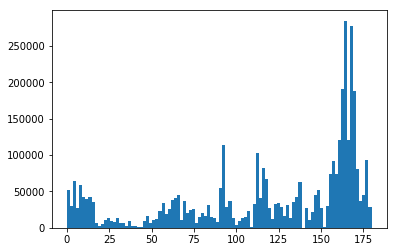

In [12]:
plt.hist(se['clock_direction_degrees'], bins=100);

In [13]:
se['clock_direction_degrees'] = se['clock_direction_degrees'].replace(np.nan, np.mean(se['clock_direction_degrees']))


In [14]:
se['self_offset_5_1'] = se['self_offset_5_1'].fillna(0)

for i in range(2,5):
      se[f'self_offset_5_{i}'] = se[f'self_offset_5_{i}'].fillna(se[f'self_offset_5_{i-1}'])

for i in range(1,5):
    for j in range(1,5):
    
        if i == 1:
            se[f'prev_stop_1_offset_5_{j}'] = se[f'prev_stop_1_offset_5_{j}'].fillna(se[f'self_offset_5_{j}']) 
            se[f'next_stop_1_offset_5_{j}'] = se[f'next_stop_1_offset_5_{j}'].fillna(se[f'self_offset_5_{j}']) 
        else:
            se[f'prev_stop_{i}_offset_5_{j}'] = se[f'prev_stop_{i}_offset_5_{j}'].fillna(se[f'prev_stop_{i-1}_offset_5_{j}']) 
            se[f'next_stop_{i}_offset_5_{j}'] = se[f'prev_stop_{i}_offset_5_{j}'].fillna(se[f'prev_stop_{i-1}_offset_5_{j}']) 



In [15]:
se = se.replace(np.nan, 0)

In [16]:
to_remove = ['mean', 'prev_stop_', 'next_stop_', ]

min_cols = [c for c in se.columns if not any(x in c for x in to_remove)]

se_min = se[min_cols]

In [17]:
se['road_offset_5_1'] = se[['prev_stop_4_offset_5_1', 
                            'prev_stop_3_offset_5_1', 
                            'prev_stop_2_offset_5_1', 
                            'prev_stop_1_offset_5_1',
                           'self_offset_5_1',
                           'next_stop_1_offset_5_1', 
                            'next_stop_2_offset_5_1', 
                            'next_stop_3_offset_5_1', 
                            'next_stop_4_offset_5_1']].values.tolist()

se['road_offset_5_2'] = se[['prev_stop_4_offset_5_2', 
                            'prev_stop_3_offset_5_2', 
                            'prev_stop_2_offset_5_2', 
                            'prev_stop_1_offset_5_2',
                           'self_offset_5_2',
                           'next_stop_1_offset_5_2', 
                            'next_stop_2_offset_5_2', 
                            'next_stop_3_offset_5_2', 
                            'next_stop_4_offset_5_2']].values.tolist()

se['road_offset_5_3'] = se[['prev_stop_4_offset_5_3', 
                            'prev_stop_3_offset_5_3', 
                            'prev_stop_2_offset_5_3', 
                            'prev_stop_1_offset_5_3',
                           'self_offset_5_3',
                           'next_stop_1_offset_5_3', 
                            'next_stop_2_offset_5_3', 
                            'next_stop_3_offset_5_3', 
                            'next_stop_4_offset_5_3']].values.tolist()

se['road_offset_5_4'] = se[['prev_stop_4_offset_5_4', 
                            'prev_stop_3_offset_5_4', 
                            'prev_stop_2_offset_5_4', 
                            'prev_stop_1_offset_5_4',
                           'self_offset_5_4',
                           'next_stop_1_offset_5_4', 
                            'next_stop_2_offset_5_4', 
                            'next_stop_3_offset_5_4', 
                            'next_stop_4_offset_5_4']].values.tolist()

In [18]:
se['road_time_series'] = se[['road_offset_5_1', 'road_offset_5_2', 'road_offset_5_3', 'road_offset_5_4']].values.tolist()


In [19]:
# np.array(se["road_time_series"].values.tolist()).shape

In [20]:
def split_train_test(events, days):

    first_day = events["date"].min()

#     days = 75

    train = events.loc[events["date"].isin(pd.date_range(first_day, periods=days))]

    test = events.loc[
        events["date"].isin(
            pd.date_range(first_day + pd.Timedelta(f"{days + 1} day"), periods=14)
        )]
    
    return train, test

In [21]:
train, test = split_train_test(se_min, 75)

train_st, test_st = split_train_test(se[['road_time_series', 'date', 'diff_percent_segment_and_median_by_segment_code_and_hour_and_day', 'segment_duration']], 75)

In [22]:
# train_matrix = stop_events[stop_events['train']][['line_distance', 'to_centre_dist', 'direction_degrees', 'best_0', 'best_1', 'best_2', 'best_3', 'best_4', 'best_5', 'best_6', 'best_7', 'best_8', 'best_9', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39']].values
train_matrix = train.drop(["diff_percent_segment_and_median_by_segment_code_and_hour_and_day", 'date', 'segment_duration'], axis=1)
train_matrix_st = train_st.drop(["diff_percent_segment_and_median_by_segment_code_and_hour_and_day", 'date', 'segment_duration'], axis=1)
train_target = train["diff_percent_segment_and_median_by_segment_code_and_hour_and_day"]

# test_matrix = stop_events[stop_events['test']][['line_distance', 'to_centre_dist', 'direction_degrees', 'best_0', 'best_1', 'best_2', 'best_3', 'best_4', 'best_5', 'best_6', 'best_7', 'best_8', 'best_9', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39']].values
test_matrix = test.drop(["diff_percent_segment_and_median_by_segment_code_and_hour_and_day", "date", 'segment_duration'], axis=1)
test_matrix_st = test_st.drop(["diff_percent_segment_and_median_by_segment_code_and_hour_and_day", "date", 'segment_duration'], axis=1)
test_target = test["diff_percent_segment_and_median_by_segment_code_and_hour_and_day"]

In [23]:
print(train_target.min())
print(train_target.max())

print(test_target.min())
print(test_target.max())

-14925.0
inf
-3482.608695652174
10467.441860465116


In [24]:
# se[se['diff_percent_segment_and_median_by_segment_code_and_hour_and_day'] > 5000][['segment_duration', 'timetable_segment_duration', 'median_durations_by_segment_code_and_hour_and_day']]

In [25]:
train_target = np.nan_to_num(train_target)
test_target = np.nan_to_num(test_target)

In [26]:
train_target = np.clip(train_target, -1000, 10000)
test_target = np.clip(test_target, -1000, 10000)

In [27]:
train_matrix_st = np.array(train_matrix_st.values.tolist()).squeeze()
test_matrix_st = np.array(test_matrix_st.values.tolist()).squeeze()

In [28]:

print(train_matrix_st.shape)
print(test_matrix_st.shape)

(3257131, 4, 9)
(661623, 4, 9)


In [29]:
# se.columns

In [30]:
reg = LinearRegression().fit(train_matrix, train_target)

reg_results = reg.predict(test_matrix)

In [31]:
reg.score(test_matrix, test_target)



0.16819064376854587

In [32]:
rmse_lr = np.sqrt(mean_squared_error(test_target, reg_results))
mae_lr = mean_absolute_error(test_target, reg_results)


In [33]:
print(rmse_lr)
print(mae_lr)


91.25130548613238
39.30237304982279


(array([ 2.,  2.,  3.,  1.,  2., 31.,  1.,  3.,  4.,  3.]),
 array([-42.5606705 , -34.98217437, -27.40367823, -19.8251821 ,
        -12.24668596,  -4.66818982,   2.91030631,  10.48880245,
         18.06729859,  25.64579472,  33.22429086]),
 <a list of 10 Patch objects>)

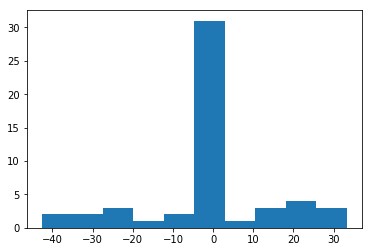

In [34]:
plt.hist(reg.coef_)

In [35]:
# data_dmatrix = xgb.DMatrix(data=train_matrix,label=train_target)


In [36]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', eval_metric='mae', booster='gbtree', n_jobs=5, max_depth=5, n_estimators=100, verbosity=1)


In [37]:
xg_reg.fit(train_matrix, train_target)

xg_reg.save_model("xg_model_xgboost")

# xg_reg.load_model("xg_model_xgboost")

In [38]:
xg_reg_results = xg_reg.predict(test_matrix)

In [39]:
rmse_xg = np.sqrt(mean_squared_error(test_target, xg_reg_results))
mae_xg = mean_absolute_error(test_target, xg_reg_results)

In [40]:
print(rmse_xg)
print(mae_xg)

83.5568248477292
36.33848954736486


In [41]:

rf_reg = xgb.XGBRegressor(objective ='reg:linear', eval_metric='mae', booster='gbtree', n_jobs=5, max_depth=10, verbosity=2, colsample_bynode=0.8, learning_rate=1, num_parallel_tree=100, subsample=0.8, tree_method='hist')


In [42]:
rf_reg.fit(train_matrix, train_target)

rf_reg.save_model("rf_model_xgboost")

# rf_reg.load_model("rf_model_xgboost")

In [43]:
rf_reg_results = rf_reg.predict(test_matrix)

In [44]:
rmse_rf = np.sqrt(mean_squared_error(test_target, rf_reg_results))
mae_rf = mean_absolute_error(test_target, rf_reg_results)

In [45]:
print(rmse_rf)
print(mae_rf)

82.03259637518343
33.93585245832567


In [46]:
test_matrix.columns[np.argsort(rf_reg.feature_importances_)[::-1]]

Index(['arrival_hour_5', 'median_full_durations_by_segment_code',
       'median_durations_by_segment_code', 'self_offset_5_1', 'arrival_hour_0',
       'timingPoint', 'arrival_hour_6',
       'median_dwell_prev_durations_by_stop_code', 'arrival_hour_23',
       'self_offset_5_3', 'arrival_hour_7',
       'median_dwell_dest_durations_by_stop_code', 'self_offset_5_2',
       'timetable_segment_duration', 'median_dwell_dest_by_stop_code_and_hour',
       'clock_direction_degrees', 'direction_degrees', 'to_centre_dist',
       'median_dwell_dest_by_stop_code_and_hour_and_day', 'arrival_hour_9',
       'median_full_durations_by_segment_code_and_hour_and_day',
       'arrival_hour_20', 'arrival_hour_19', 'arrival_day_6',
       'arrival_hour_17', 'median_dwell_prev_by_stop_code_and_hour',
       'line_distance', 'median_durations_by_segment_code_and_hour_and_day',
       'median_dwell_prev_by_stop_code_and_hour_and_day',
       'median_durations_by_segment_code_and_hour', 'scheduledStart',


In [47]:
test_matrix.columns[np.argsort(xg_reg.feature_importances_)[::-1]]

Index(['median_full_durations_by_segment_code', 'self_offset_5_1',
       'self_offset_5_3', 'median_dwell_prev_durations_by_stop_code',
       'timingPoint', 'median_durations_by_segment_code_and_hour_and_day',
       'median_durations_by_segment_code', 'arrival_hour_9',
       'median_dwell_dest_durations_by_stop_code', 'arrival_hour_0',
       'median_dwell_dest_by_stop_code_and_hour_and_day',
       'median_dwell_prev_by_stop_code_and_hour',
       'median_dwell_dest_by_stop_code_and_hour', 'timetable_segment_duration',
       'median_dwell_prev_by_stop_code_and_hour_and_day', 'line_distance',
       'self_offset_5_2', 'median_durations_by_segment_code_and_hour',
       'to_centre_dist', 'direction_degrees',
       'median_full_durations_by_segment_code_and_hour_and_day',
       'arrival_day_3', 'clock_direction_degrees', 'arrival_hour_23',
       'median_full_durations_by_segment_code_and_hour', 'arrival_day_5',
       'scheduledStart', 'self_offset_5_4', 'arrival_hour_17', 'rain'

In [48]:
train_matrix_st.shape

(3257131, 4, 9)

## Network section

### Scaling

In [49]:
scaler_matrix = preprocessing.StandardScaler().fit(train_matrix)

train_matrix_scaled = scaler_matrix.transform(train_matrix)
test_matrix_scaled = scaler_matrix.transform(test_matrix)

scaler_target = preprocessing.StandardScaler().fit(train_target[:,None])

train_target_scaled = scaler_target.transform(train_target[:,None])
test_target_scaled = scaler_target.transform(test_target[:,None])

st_scaler = preprocessing.StandardScaler()
train_matrix_st_shape = train_matrix_st.shape
test_matrix_st_shape = test_matrix_st.shape
train_matrix_st = st_scaler.fit_transform(train_matrix_st.reshape(len(train_target_scaled), -1)).reshape(train_matrix_st_shape)
test_matrix_st = st_scaler.transform(test_matrix_st.reshape(len(test_target_scaled), -1)).reshape(test_matrix_st_shape)
# for i in range(train_matrix_st.shape[2]):
#     train_matrix_st[:, :, i] = st_scaler.transform(train_matrix_st[:, :, i]) 

# for i in range(test_matrix_st.shape[2]):
#     test_matrix_st[:, :, i] = st_scaler.transform(test_matrix_st[:, :, i]) 

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


### Fully connected

In [50]:
def create_fully_connected(input_width):
    model = Sequential()
    
    model.add(Dense(32, input_dim=input_width, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(Dense(12, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(Dense(12, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(Dense(1, activation='tanh'))
    model.summary()
    
    return model

In [51]:
model = create_fully_connected(train_matrix.shape[1])

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
    keras.callbacks.ModelCheckpoint(filepath='full_conn_model.h5', monitor='val_loss', save_best_only=True)
]

model.compile(optimizer='adam',
              loss='mean_absolute_error',
              metrics=['MAE'])
history = model.fit(train_matrix_scaled, train_target_scaled,
                    epochs=10,
                    callbacks=callbacks_list,
                    batch_size=512,
                    validation_data=(test_matrix_scaled, test_target_scaled))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1696      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                396       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                156       
_________________________________________________________________
dropout_3 (Dropout)  

In [52]:
model_to_load = 'full_conn_model.h5'

# Create the network and load the weights into it
model = create_fully_connected(test_matrix.shape[1])
model.load_weights(model_to_load)

model.compile(optimizer='rmsprop',
              loss='mean_absolute_error',
              metrics=['acc'])
test_y_scaled = model.predict(test_matrix_scaled)

NN_results = scaler_target.inverse_transform(test_y_scaled).squeeze()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                1696      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 12)                396       
_________________________________________________________________
dropout_5 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 12)                156       
_________________________________________________________________
dropout_6 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 13        
Total para

In [53]:
rmse_NN = np.sqrt(mean_squared_error(test_target, NN_results))
mae_NN = mean_absolute_error(test_target, NN_results)



In [54]:
print(rmse_NN)
print(mae_NN)

96.37559727902867
33.60809916860867


### LSTM

In [55]:
def create_LSTM(input_shape):
    
    model = Sequential()
    
    model.add(LSTM(40, input_shape=input_shape))
    model.add(layers.Dropout(rate=0.2))
    model.add(Dense(24, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(Dense(12, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(Dense(12, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(Dense(1, activation='tanh'))
    model.summary()
    
    return model

In [56]:
model = create_LSTM((train_matrix_st.shape[1], train_matrix_st.shape[2]))

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
    keras.callbacks.ModelCheckpoint(filepath='lstm_model.h5', monitor='val_loss', save_best_only=True)
]

model.compile(optimizer='adam',
              loss='mean_absolute_error',
              metrics=['MAE'])
history = model.fit(train_matrix_st, train_target_scaled,
                    epochs=10,
                    callbacks=callbacks_list,
                    batch_size=512,
                    validation_data=(test_matrix_st, test_target_scaled))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40)                8000      
_________________________________________________________________
dropout_7 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 24)                984       
_________________________________________________________________
dropout_8 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 12)                300       
_________________________________________________________________
dropout_9 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 12)                156       
__________

In [57]:
model_to_load = 'lstm_model.h5'

# Create the network and load the weights into it
model = create_LSTM((train_matrix_st.shape[1], train_matrix_st.shape[2]))
model.load_weights(model_to_load)

model.compile(optimizer='rmsprop',
              loss='mean_absolute_error',
              metrics=['MAE'])
test_y_scaled = model.predict(test_matrix_st)

NN_lstm_results = scaler_target.inverse_transform(test_y_scaled).squeeze()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 40)                8000      
_________________________________________________________________
dropout_11 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 24)                984       
_________________________________________________________________
dropout_12 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 12)                300       
_________________________________________________________________
dropout_13 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 12)                156       
__________

In [58]:
rmse_NN_lstm = np.sqrt(mean_squared_error(test_target, NN_lstm_results))
mae_NN_lstm = mean_absolute_error(test_target, NN_lstm_results)


In [59]:
print(rmse_NN_lstm)
print(mae_NN_lstm)

97.98262583979275
35.040458405650206


### Combined

In [60]:
def create_combined_model(road_input_shape, aux_input_shape):
    
    # Headline input: meant to receive road time series.
    main_input = Input(shape=road_input_shape, dtype='float32', name='road_time_input')
    lstm_out = LSTM(40)(main_input)
    
    auxiliary_output = Dense(1, activation='tanh', name='aux_output')(lstm_out)
    
    auxiliary_input = Input(shape=(aux_input_shape,), name='aux_input')
    x = keras.layers.concatenate([lstm_out, auxiliary_input])

    # We stack a deep densely-connected network on top
    x = Dense(32, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(12, activation='relu')(x)
    x = Dense(12, activation='relu')(x)

    # And finally we add the main output layer
    main_output = Dense(1, activation='tanh', name='main_output')(x)
    
    model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])
    
    model.summary()
    
    return model

In [61]:
model = create_combined_model((train_matrix_st.shape[1], train_matrix_st.shape[2]), train_matrix_scaled.shape[1])

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
    keras.callbacks.ModelCheckpoint(filepath='combined_model.h5', monitor='val_loss', save_best_only=True)
]

model.compile(optimizer='rmsprop',
              loss='mean_absolute_error',
              metrics=['MAE'], loss_weights=[1,0.2])
history = model.fit([train_matrix_st, train_matrix_scaled], [train_target_scaled,train_target_scaled],
                    epochs=10,
                    callbacks=callbacks_list,
                    batch_size=512,
                    validation_data=([test_matrix_st, test_matrix_scaled], [test_target_scaled, test_target_scaled]))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 4, 9)         0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 40)           8000        road_time_input[0][0]            
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 52)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 92)           0           lstm_3[0][0]                     
                                                                 aux_input[0][0]                  
__________

In [64]:
model_to_load = 'combined_model.h5'

# Create the network and load the weights into it
model = create_combined_model((train_matrix_st.shape[1], train_matrix_st.shape[2]), train_matrix.shape[1])
model.load_weights(model_to_load)

model.compile(optimizer='rmsprop',
              loss='mean_absolute_error',
              metrics=['MAE'])
test_y_scaled, _ = model.predict([test_matrix_st, test_matrix_scaled])

NN_combined_results = scaler_target.inverse_transform(test_y_scaled).squeeze()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 4, 9)         0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 40)           8000        road_time_input[0][0]            
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 52)           0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 92)           0           lstm_5[0][0]                     
                                                                 aux_input[0][0]                  
__________

In [65]:
rmse_NN_combined = np.sqrt(mean_squared_error(test_target, NN_combined_results))
mae_NN_combined = mean_absolute_error(test_target, NN_combined_results)



In [66]:
print(rmse_NN_combined)
print(mae_NN_combined)

95.63139484154922
32.32356788671386


In [67]:
NN_results.shape

(661623,)

In [68]:
rf_reg_results.shape

(661623,)

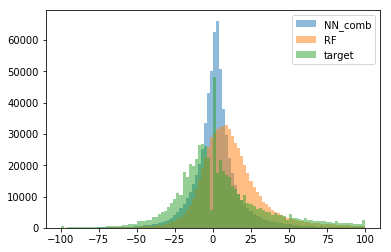

In [82]:
# plt.hist(NN_results, alpha=0.5, bins=100, label="NN", range=(-100, 100))
plt.hist(NN_combined_results, alpha=0.5, bins=100, label="NN_comb", range=(-100, 100))
# plt.hist(NN_lstm_results, alpha=0.5, bins=100, label="NN_lstm", range=(-100, 100))
# plt.hist(xg_reg_results, bins=100, label="XGB", alpha=0.5,  range=(-100, 100))
plt.hist(rf_reg_results, bins=100, label="RF", alpha=0.5,  range=(-100, 100))
# plt.hist(reg_results, bins=100, label="Linear", alpha=0.5,  range=(-100, 100))
# plt.hist(stop_events[stop_events['test']]['best_0'], bins=100, alpha=0.5,  label="best_0", range=(-100, 100))
# # plt.hist(stop_events['diff_percent_full_segment_and_median_by_segment_code_and_hour_and_day'], bins=200, label="target", range=(-100, 100))
# # plt.hist(train_target, bins=200, label="train", range=(-100, 100))
plt.hist(test_target, bins=100, label="target", alpha=0.5,  range=(-100, 100))
# plt.yscale("log")
plt.legend()

plt.show()


In [69]:
def MAPE(forecast, actual):
    
    if(len(forecast) != len(actual)):
        raise ValueError('Could not calculate MAPE, forecast and actual arrays are different length')
        
    forecast = np.asarray(forecast)
    actual = np.asarray(actual)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        
        division = (actual-forecast)/actual
        
        division[actual == 0] = 0
        
        # Instead of dividing by n we count by the number of non-zero values. 
        # Essentially ignoring all cases where the actual value is zero. 
        mape = 100 / np.count_nonzero(actual) * np.sum(np.abs(division))
    
    return mape

In [70]:
predict_reg = test["median_durations_by_segment_code_and_hour_and_day"].values * (1+(reg_results/100))

In [71]:
predict_xg = test["median_durations_by_segment_code_and_hour_and_day"].values * (1+(xg_reg_results/100))

In [72]:
predict_NN = test["median_durations_by_segment_code_and_hour_and_day"].values * (1+(NN_results/100))

In [73]:
predict_self_offset = test["median_durations_by_segment_code_and_hour_and_day"].values * (1+(test['self_offset_5_1'].values/100))

In [74]:
predict_rf = test["median_durations_by_segment_code_and_hour_and_day"].values * (1+(rf_reg_results/100))

In [75]:
predict_NN_lstm = test["median_durations_by_segment_code_and_hour_and_day"].values * (1+(NN_lstm_results/100))

In [76]:
predict_NN_combined = test["median_durations_by_segment_code_and_hour_and_day"].values * (1+(NN_combined_results/100))


In [77]:
predict_null = test["median_durations_by_segment_code_and_hour_and_day"].values

In [78]:
print(f"Medians only MAPE: {MAPE(predict_null, test['segment_duration'])}")

print(f"Linear MAPE: {MAPE(predict_reg, test['segment_duration'])}")
      
print(f"XGBoost MAPE: {MAPE(predict_xg, test['segment_duration'])}")
      
print(f"NN MAPE: {MAPE(predict_NN, test['segment_duration'])}")
      
print(f"LSTM MAPE: {MAPE(predict_NN_lstm, test['segment_duration'])}")
      
print(f"NN combined MAPE: {MAPE(predict_NN_combined, test['segment_duration'])}")
            
print(f"RF MAPE: {MAPE(predict_rf, test['segment_duration'])}")
      
print(f"self_offset MAPE: {MAPE(predict_self_offset, test['segment_duration'])}")

Medians only MAPE: 26.37532518182463
Linear MAPE: 33.333357305858854
XGBoost MAPE: 31.19870715307047
NN MAPE: 23.60351871867299
LSTM MAPE: 24.814817258218763
NN combined MAPE: 22.37573945285785
RF MAPE: 29.050791745384423
self_offset MAPE: 36.7144039357816


In [ ]:
# plt.hist(stop_events['30'], bins=100);

In [ ]:
# MAPE(stop_events[stop_events['test']]['median_full_durations_by_segment_code_and_hour_and_day'], stop_events[stop_events['test']]['full_duration'])


In [ ]:
os.system("say -v Fiona Go check your results - Kitchen Sink") 